In [1]:
from functools import partial

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images

In [2]:
print = partial(print, flush=True)

In [3]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
class CFG:
    model_type = 'LightGBM'
    num_popular_items = 12
    train_weeks = 2
    repurchase_weeks = 16
    cooc_weeks = 12
    cooc_threshold = 0.03
    dynamic_feature_weeks = 8
    volume_feature_weeks = 1


# BEST
# class CFG:
#     model_type = 'CatBoost'
#     num_popular_items = 12
#     train_weeks = 3
#     repurchase_weeks = 40
#     cooc_weeks = 12
#     cooc_threshold = 0.03073
#     dynamic_feature_weeks = 8
#     volume_feature_weeks = 1

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.num_popular_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.num_popular_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= @CFG.cooc_threshold").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, week + CFG.repurchase_weeks)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week, week)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, week + CFG.cooc_weeks, candidates_repurchase)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]

    candidates = pd.concat(candidates).reset_index(drop=True)
    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    return candidates


In [6]:
# valid: week=1
# train: week=2..1+CFG.train_weeks
candidates = []
for week in range(1, 2+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 2
volume: 837645
duplicates: 1.1004674370575902
            strategy  volume     ratio
0  same_product_code  360668  0.430574
1               cooc  322533  0.385047
2                pop   82356  0.098319
3         repurchase   72088  0.086060
week: 3
volume: 979752
duplicates: 1.1117879351822433
            strategy  volume     ratio
0               cooc  430947  0.439853
1  same_product_code  386334  0.394318
2                pop   85032  0.086789
3         repurchase   77439  0.079039
week: 4
volume: 1028697
duplicates: 1.1112230943229913
            strategy  volume     ratio
0               cooc  451346  0.438755
1  same_product_code  406843  0.395494
2                pop   90528  0.088003
3         repurchase   79980  0.077749


In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [8]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


week: 1
Recall: 0.07784318342359313
            strategy      y  volume    recall  hit_ratio
0  same_product_code  795.0  360668  0.037438   0.002204
1         repurchase  593.0   72088  0.027926   0.008226
2                pop  442.0   82356  0.020815   0.005367
3               cooc  175.0  322533  0.008241   0.000543
week: 2
Recall: 0.08062925779849409
            strategy      y  volume    recall  hit_ratio
0  same_product_code  908.0  386334  0.040696   0.002350
1         repurchase  628.0   77439  0.028146   0.008110
2                pop  432.0   85032  0.019362   0.005080
3               cooc  256.0  430947  0.011474   0.000594
week: 3
Recall: 0.07401755055322395
            strategy      y  volume    recall  hit_ratio
0  same_product_code  762.0  406843  0.032303   0.001873
1         repurchase  595.0   79980  0.025224   0.007439
2                pop  514.0   90528  0.021790   0.005678
3               cooc  246.0  451346  0.010429   0.000545


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 837645 -> 231072
drop trivial queries: 979752 -> 279078
drop trivial queries: 1028697 -> 280822


In [10]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    week_end = week + CFG.volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # week_end = week + CFG.volume_feature_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    week_end = week + CFG.volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

week: 2
week: 2
week: 3
week: 4


In [11]:
for idx in range(len(candidates)):
    candidates[idx]['query_group'] = candidates[idx]['week'].astype(str) + '_' + candidates[idx]['user'].astype(str)
    candidates[idx] = candidates[idx].sort_values(by='query_group').reset_index(drop=True)

In [12]:
def concat_train(candidates, begin, num):
    train = pd.concat([candidates[idx] for idx in range(begin, begin+num)])
    return train

valid = candidates[0]
train = concat_train(candidates, 1, CFG.train_weeks)

In [13]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [14]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [15]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

[LightGBM] [Info] Total groups: 2664, total data: 559900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5415
[LightGBM] [Info] Number of data points in the train set: 559900, number of used features: 41
[LightGBM] [Info] Total groups: 1239, total data: 231072
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	training's map@12: 0.354035	valid_1's map@12: 0.252523


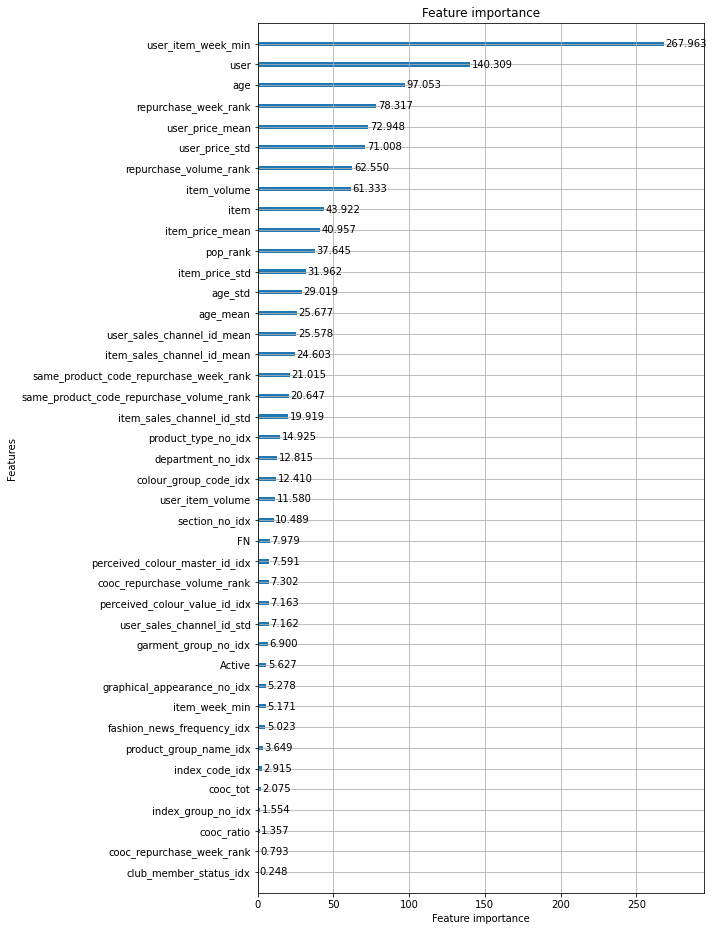

In [16]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
    }
    model = catboost.CatBoost(params)
    model.fit(train_pool, eval_set=valid_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [17]:
valid_all['pred'] = model.predict(valid_all[feature_columns])
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()


In [18]:
gt = transactions.query("week == 1").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

mapk(merged['gt'], merged['item'])

0.027360462402818506

In [19]:
# assert False

submission

In [20]:
train = concat_train(candidates, 0, CFG.train_weeks)

[LightGBM] [Info] Total groups: 2562, total data: 510150
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5343
[LightGBM] [Info] Number of data points in the train set: 510150, number of used features: 41


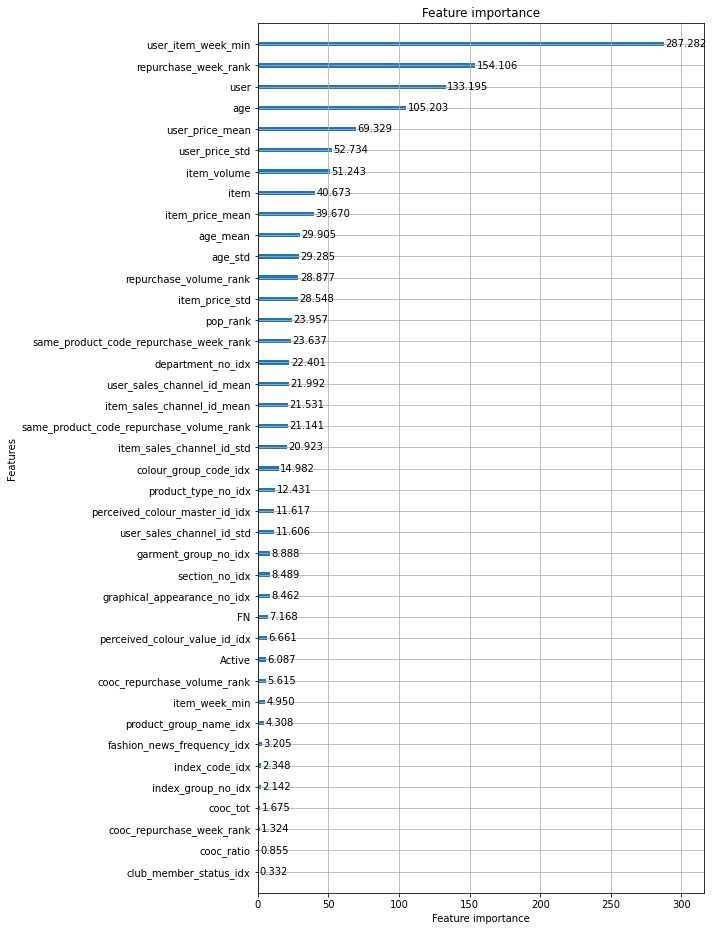

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [22]:
all_users = users['user'].values
all_users

array([     0,      1,      2, ..., 137195, 137196, 137197])

In [23]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 1)
    candidates = attach_features(transactions, users, items, candidates, 1)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

week: 1
volume: 710986
duplicates: 1.0766479397913291
            strategy  volume     ratio
0  same_product_code  265932  0.374033
1               cooc  232576  0.327118
2                pop  164640  0.231566
3         repurchase   47838  0.067284
week: 1
week: 1
volume: 718414
duplicates: 1.0788211885722867
            strategy  volume     ratio
0  same_product_code  268162  0.373269
1               cooc  236445  0.329121
2                pop  164640  0.229171
3         repurchase   49167  0.068438
week: 1
week: 1
volume: 691084
duplicates: 1.0728635765948562
            strategy  volume     ratio
0  same_product_code  252883  0.365922
1               cooc  226874  0.328287
2                pop  164640  0.238234
3         repurchase   46687  0.067556
week: 1
week: 1
volume: 684459
duplicates: 1.071924238841219
            strategy  volume     ratio
0  same_product_code  253715  0.370680
1               cooc  220240  0.321772
2                pop  164640  0.240540
3         repurchase

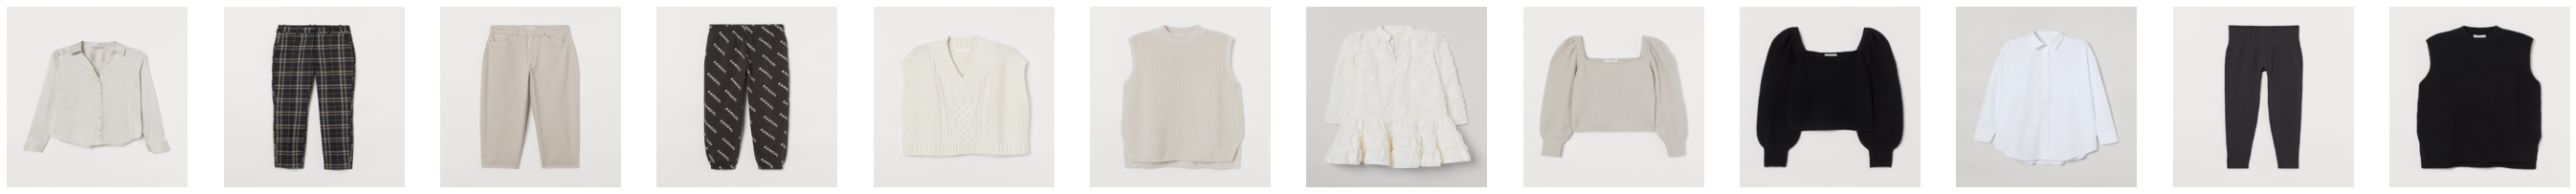

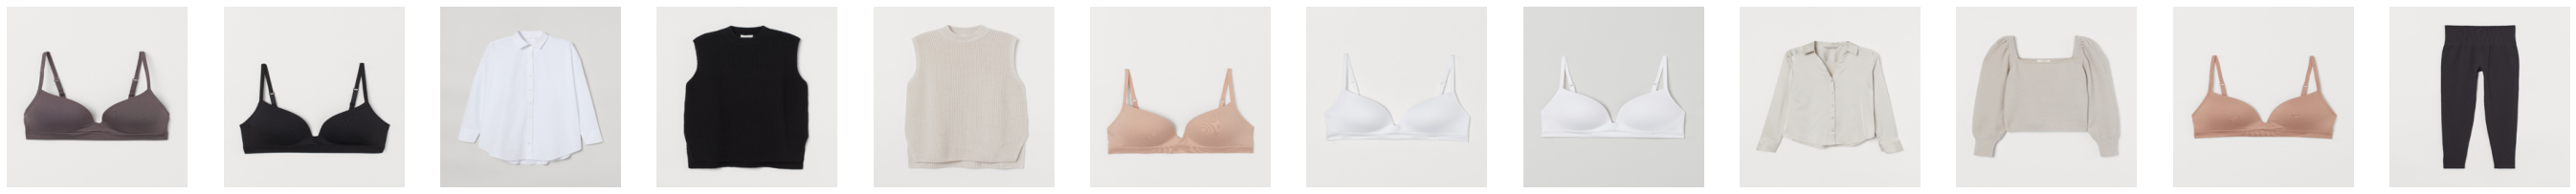

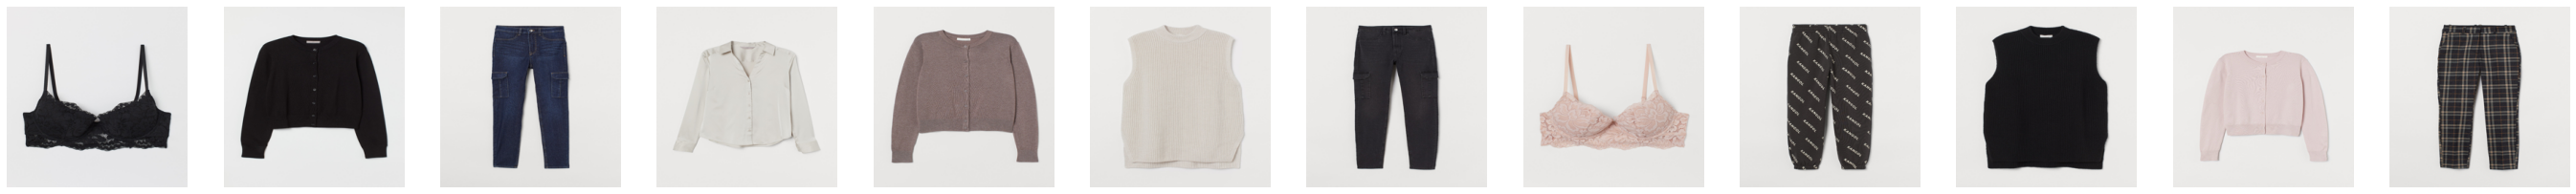

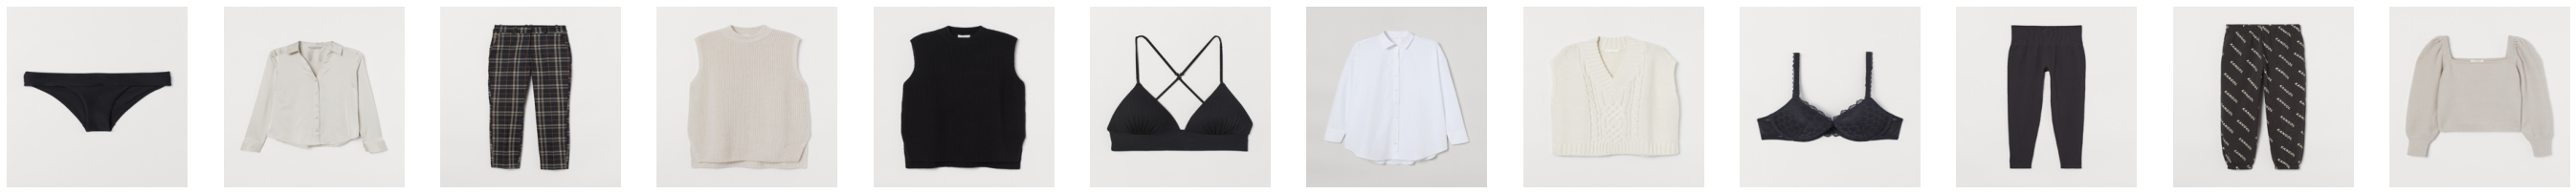

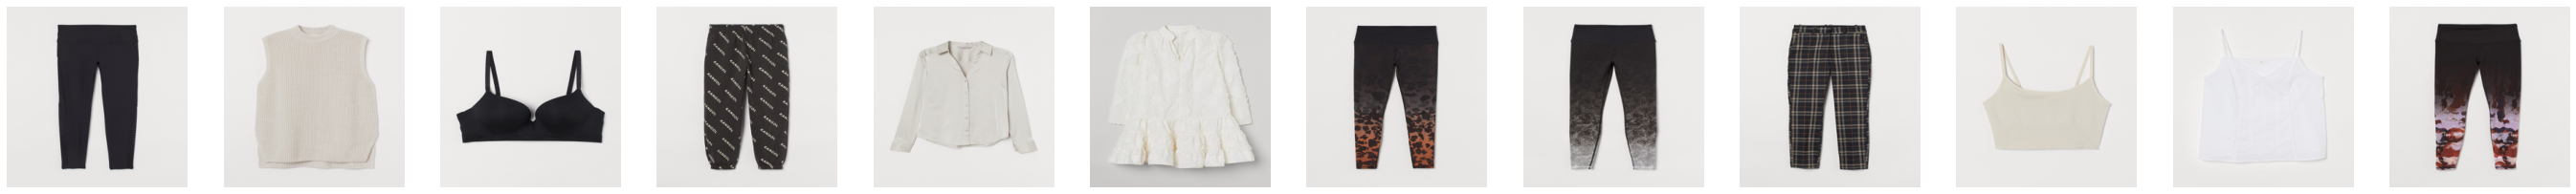

In [24]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [25]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,7f1233293cc6ff19b226f60d66a8d11709947554223107...,0762846027 0751471043 0865799006 0904571001 09...
1,a52b6a1ce0003caa79cb85491606415f16efa502d046b9...,0855080009 0855080001 0923758001 0924243002 09...
2,b051873c9de518c2271755695d56c8c0cb96dcc969f363...,0885951001 0579541001 0788575004 0762846027 05...
3,28fc996fe679cb890b91010a6a4cd3ffd61d3846b24e0e...,0688537004 0762846027 0751471043 0924243001 09...
4,ca98b3ba46d78fc9cce3e411ebfe85c50610b6009ecb9d...,0730683050 0924243001 0707269003 0904571001 07...
...,...,...
137193,0a994cf9c074e6f77dea5a3fad098ac8e75b1e630d7a00...,0891591003 0933032002 0924243002 0924243001 09...
137194,69246fc388913a6ba01353e4ae21493e7e9610a8dca648...,0810169017 0810169002 0924243001 0810169018 09...
137195,b55e538e358cc2c00b78a926d438be22daa0f6847f4423...,0924243001 0924243002 0923758001 0751471043 08...
137196,37873090b5dcbaeed55d32a3033fb8f25ea281486efeb2...,0891591002 0924243001 0891591003 0924243002 09...


In [26]:
submission.to_csv('submission.csv', index=False)